# Research Question 1: What is the current performance and scaling of the Superemulator when running 6 and 36 models?

In [41]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [42]:
pip install jinja2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [43]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [44]:
pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [45]:
pip install pingouin

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [46]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import statistics


## Setup and Data Loading from Wandb

In [47]:
api = wandb.Api()
Baseline = api.runs(f"causalpaca/emulator", filters = {'group' : "Baseline", 'tags': "36_models"})
print(len(Baseline))
Model_36= api.runs(f"causalpaca/emulator", filters = {'group' : "Final", 'tags': "Final"})
print(len(Model_36))
Treatments = [Baseline,Model_36]
Treatment_Names = ["Baseline_36","Final_36"]

8
12


In [59]:
def extract_parts_from_name(name):
    """
    Extracts parts from a given name.
    """
    parts = name.split('_')
    new_name = parts[1]
    if(parts[2]=="frozen"):
      new_name = new_name +"_"+ parts[2]
    return new_name

def filter_system_metrics(system_metrics, filter_criteria):
    """
    Filters system metrics based on specified criteria.
    """
    filtered_columns = [metric[0] for metric in filter_criteria]

    return system_metrics[filtered_columns]


data = []
for index, treatment in enumerate(Treatments):

  for model in treatment:
      # Fetching metrics for the specified run
      try:
         name = model.config["model"]["model_name"]
      except: 
         name = model.config["model/model_name"]
      runtime_hours = model.summary["_wandb"].runtime / 60 / 60 # in minutes
      emissions = model.summary["emissions"]

      # Retrieving system metrics history
      default_metrics = model.history(stream="default",pandas=True)
      train_time = default_metrics["time/train"].dropna().to_numpy()
      epoch = default_metrics["epoch"].dropna().to_numpy()
      val_rmse = default_metrics['val/rmse'].ffill()
      val_rmse = val_rmse.bfill().tolist()
      
      system_metrics = model.history(stream="system",pandas=True)

      # print("defaul metrics\n")
      # print(model.scan_history())
      filter_criteria = [
          ['system.cpu'],
          ['system.gpu.process.0.gpu'],
          ['system.gpu.process.0.memoryAllocatedBytes'],
          ['system.proc.memory.rssMB'],
          ['system.memory']
      ]
      # Filtering system metrics based on the specified criteria
      system_metrics_filtered = filter_system_metrics(system_metrics, filter_criteria)
      print(statistics.mean(val_rmse))
      # Create a new DataFrame for the current row
      data.append({
        "name": name,
        "treatment": Treatment_Names[index],
        "Time/Train": train_time,
        "CPU": system_metrics_filtered['system.cpu'].dropna().to_list(),
        "GPU": system_metrics_filtered['system.gpu.process.0.gpu'].dropna().to_list(),
        "GPU-Memory in GB": [x / (1e9) for x in system_metrics_filtered['system.gpu.process.0.memoryAllocatedBytes'].dropna().to_list()],
        "RSS-Memory in GB": [x / (1000) for x in system_metrics_filtered['system.proc.memory.rssMB'].dropna().to_list()],
        "RMSE": val_rmse,
        "Epochs": epoch,
        "mem": system_metrics_filtered['system.memory'].dropna().to_list(),
        "runtime_hours": runtime_hours,
        "Co2": emissions,
      })
      print(name, statistics.mean(train_time))
# Convert the list of dictionaries to a DataFrame


0.5727869893312454
convlstm 79.367844581604
0.6915024963617324
climax_frozen 602.57470703125
0.66640782558918
unet 285.82282104492185
1.6174103760421277
climax 769.7334594726562
1.2278703513145446
unet 306.4119059244792
0.5589867134094239
convlstm 76.92309443155925
0.6582270333170891
climax_frozen 567.2363891601562
1.491135091304779
climax 743.9059448242188
0.26981193935871123
convlstm 59.36860792977469
0.2800958294570446
unet 98.69324063583159
0.31780891355872154
climax_frozen 317.6414804458618
0.4154618553891778
climax 331.4325286865234
0.2805030475854874
convlstm 57.68900513648987
0.2809415645599365
unet 74.76819704495944
0.32405741146206857
climax_frozen 333.50773366292316
0.42081799429655076
climax 328.9126097026624
0.4200065182596445
climax 435.37877655029297
0.3185138893425465
climax_frozen 424.452480061849
0.2714916694164276
convlstm 51.16532728407118
0.275058975815773
unet 84.57472947714986


In [65]:
runs_count = {}
for d in data:
    key = (d["name"], d["treatment"])
    runs_count[key] = runs_count.get(key, 0) + 1
print(runs_count)

{('convlstm', 'Baseline_36'): 2, ('climax_frozen', 'Baseline_36'): 2, ('unet', 'Baseline_36'): 2, ('climax', 'Baseline_36'): 2, ('convlstm', 'Final_36'): 3, ('unet', 'Final_36'): 3, ('climax_frozen', 'Final_36'): 3, ('climax', 'Final_36'): 3}


In [72]:
# Merge the Multiples
mean_data = {}


for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    #print(number_runs)
    #print(run[0],run[1])
    CPU_Lists=[]
    GPU_Lists=[]
    RSS_Lists=[]
    mem_lst = []
    RMSE_Lists=[]
    Steps_Lists=[]
    Runtime_Lists=[]
    CO2_Lists=[]
    Time_train_list = []
    GPU_Mem_List = []
    for d in data: 
        if d["name"] == run[0] and d["treatment"] == run[1]:
            CPU_Lists.append(d["CPU"])
            GPU_Lists.append(d["GPU"])
            RSS_Lists.append(d["RSS-Memory in GB"])
            GPU_Mem_List.append(d["GPU-Memory in GB"])
            RMSE_Lists.append(d["RMSE"])
            mem_lst.append(d["mem"])
            Steps_Lists.append(d["Epochs"])
            Runtime_Lists.append(d["runtime_hours"])
            CO2_Lists.append(d["Co2"])
            Time_train_list.append(d["Time/Train"])
    
    print(len(RMSE_Lists))
    if (number_runs>=2):
        mean_data[(run[0], run[1])] = {
            "CPU": [(x + y)/2 for x, y in zip(CPU_Lists[0], CPU_Lists[1])],
            "time/train": [(x + y)/2 for x, y in zip(Time_train_list[0], Time_train_list[1])],
            "GPU": [(x + y)/2 for x, y in zip(GPU_Lists[0], GPU_Lists[1])],
            "RSS-Memory in GB": [(x + y)/2 for x, y in zip(RSS_Lists[0], RSS_Lists[1])],
            "GPU-Memory in GB":[(x + y)/2 for x, y in zip(GPU_Mem_List[0], GPU_Mem_List[1])],
            "RMSE": (min(RMSE_Lists[0])+min(RMSE_Lists[1]))/2,
            "mem":  [(x + y)/2 for x, y in zip(mem_lst[0], mem_lst[1])],
            "Epochs": [(x + y)/2 for x, y in zip(Steps_Lists[0], Steps_Lists[1])],
            "runtime_hours": statistics.mean(Runtime_Lists),
            "Co2": statistics.mean(CO2_Lists)
        }
    else:
        print("skipped")



2
2
2
2
3
3
3
3


## Overview of Mean, Median and STD

In [69]:
import math

data_scheme={
    "CPU": [(x + y)/2 for x, y in zip(CPU_Lists[0], CPU_Lists[1])],
    "time/train": [(x + y)/2 for x, y in zip(Time_train_list[0], Time_train_list[1])],
    "GPU": [(x + y)/2 for x, y in zip(GPU_Lists[0], GPU_Lists[1])],
    "RSS-Memory in GB": [(x + y)/2 for x, y in zip(RSS_Lists[0], RSS_Lists[1])],
    "RMSE": [(x + y)/2 for x, y in zip(RMSE_Lists[0], RMSE_Lists[1])],
    "Epochs": [(x + y)/2 for x, y in zip(Steps_Lists[0], Steps_Lists[1])],
    "runtime_minutes": statistics.mean(Runtime_Lists),
    "Co2": statistics.mean(CO2_Lists)
}


rows = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    if(number_runs>=2):
        name = run[0]
        treatment = run[1]
        data_for_run = mean_data.get((run[0], run[1]),0)
        new_row = {
            "Name":name, 
            "Treatment":treatment, 
            "CPU_Mean": statistics.mean(data_for_run["CPU"]), 
            "CPU_Median": statistics.median(data_for_run["CPU"]), 
            "CPU_STD": statistics.stdev(data_for_run["CPU"]), 
            "GPU_Mean": statistics.mean(data_for_run["GPU"]), 
            "GPU_Median": statistics.median(data_for_run["GPU"]), 
            "Overall Memory Percent": statistics.mean(data_for_run["mem"]),
            "GPU_STD": statistics.stdev(data_for_run["GPU"]), 
            "Time/Train Mean_Minutes": statistics.mean(data_for_run["time/train"])/60,
            "Time/Train Median_Minutes": statistics.median(data_for_run["time/train"])/60,
            "Time/Train STD_Minutes": statistics.stdev(data_for_run["time/train"])/60,
            "RSS-Memory_Mean": statistics.mean(data_for_run["RSS-Memory in GB"]), 
            "GPU-Memory_Mean": statistics.mean(data_for_run["GPU-Memory in GB"]), 
            "RSS-Memory_Median": statistics.median(data_for_run["RSS-Memory in GB"]), 
            "RSS-Memory_STD": statistics.stdev(data_for_run["RSS-Memory in GB"]), 
            "RMSE": data_for_run["RMSE"], 
            "runtime_hours": data_for_run["runtime_hours"], 
            "Co2": data_for_run["Co2"]}
        
        rows.append(new_row)

already_used_name=[]
scaling_factor_rows = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment_0 = Treatment_Names[0]
        treatment_1 = Treatment_Names[1]

        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)
   
        print(data_for_run_1["RMSE"])
        new_row_scaling = {
            "Name":name, 
            "RMSE": ((data_for_run_1["RMSE"]-data_for_run_0["RMSE"])/data_for_run_0["RMSE"])*100,
            "GPU_Mean": (statistics.mean(data_for_run_1["GPU"])-statistics.mean(data_for_run_0["GPU"]))/statistics.mean(data_for_run_0["GPU"])*100,
            "runtime_hours": ((data_for_run_1["runtime_hours"]-data_for_run_0["runtime_hours"])/data_for_run_0["runtime_hours"])*100,
            "RSS-memory_mean": (statistics.mean(data_for_run_1["RSS-Memory in GB"])-statistics.mean(data_for_run_0["RSS-Memory in GB"]))/statistics.mean(data_for_run_0["RSS-Memory in GB"])*100}
        
        scaling_factor_rows.append(new_row_scaling)

scaling_df = pd.DataFrame(scaling_factor_rows)
new_df = pd.DataFrame(rows)
finalized_data = new_df.sort_values(by='Treatment')
finalized_data = new_df.sort_values(by=['Name','Treatment'])
finalized_data_scaling_df = scaling_df.sort_values(by=['Name'])

def round_if_float(x):
    if isinstance(x, float):
        rounded_value = round(x, 3)
        return rounded_value
    return x
finalized_data = finalized_data.applymap(round_if_float)
finalized_data_scaling_df = finalized_data_scaling_df.applymap(round_if_float)
selected_columns = ['Name', 'Treatment',"CPU_Mean","GPU_Mean","RSS-Memory_Mean","RMSE","GPU-Memory_Mean","runtime_hours","Overall Memory Percent"]
selected_column = ['Name', 'Treatment',"RMSE"]

new_df = finalized_data[selected_column].copy()

latex_table = new_df.to_latex(index=False,float_format="%.3f")
latex_finalized_data_scaling_df = finalized_data_scaling_df.to_latex(index=False,float_format="%.3f")

smaller_table = new_df.to_latex(index=False,float_format="%.3f")

#print(latex_table)
print("\n")
print(latex_table)


#print(smaller_table)



[0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.28378450870513916, 0.2837845087

TypeError: unsupported operand type(s) for -: 'list' and 'list'

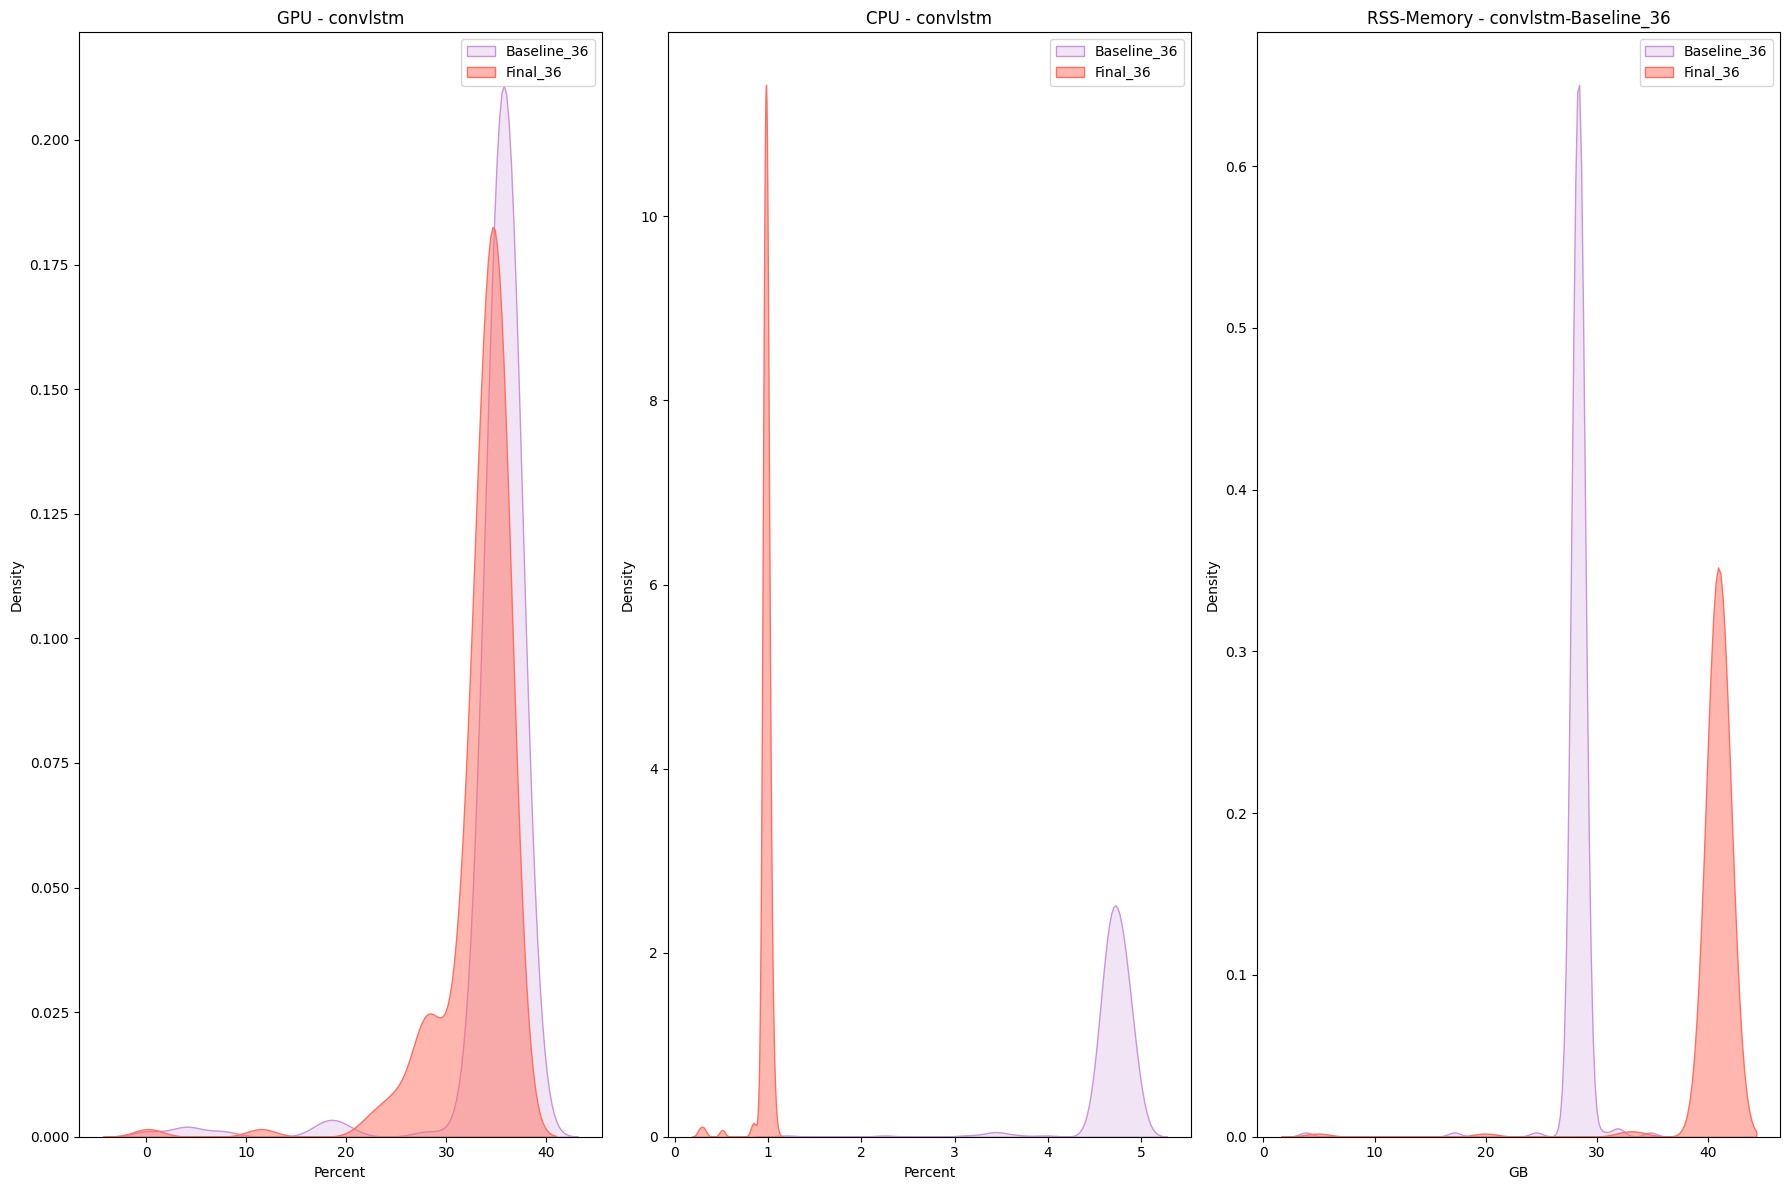

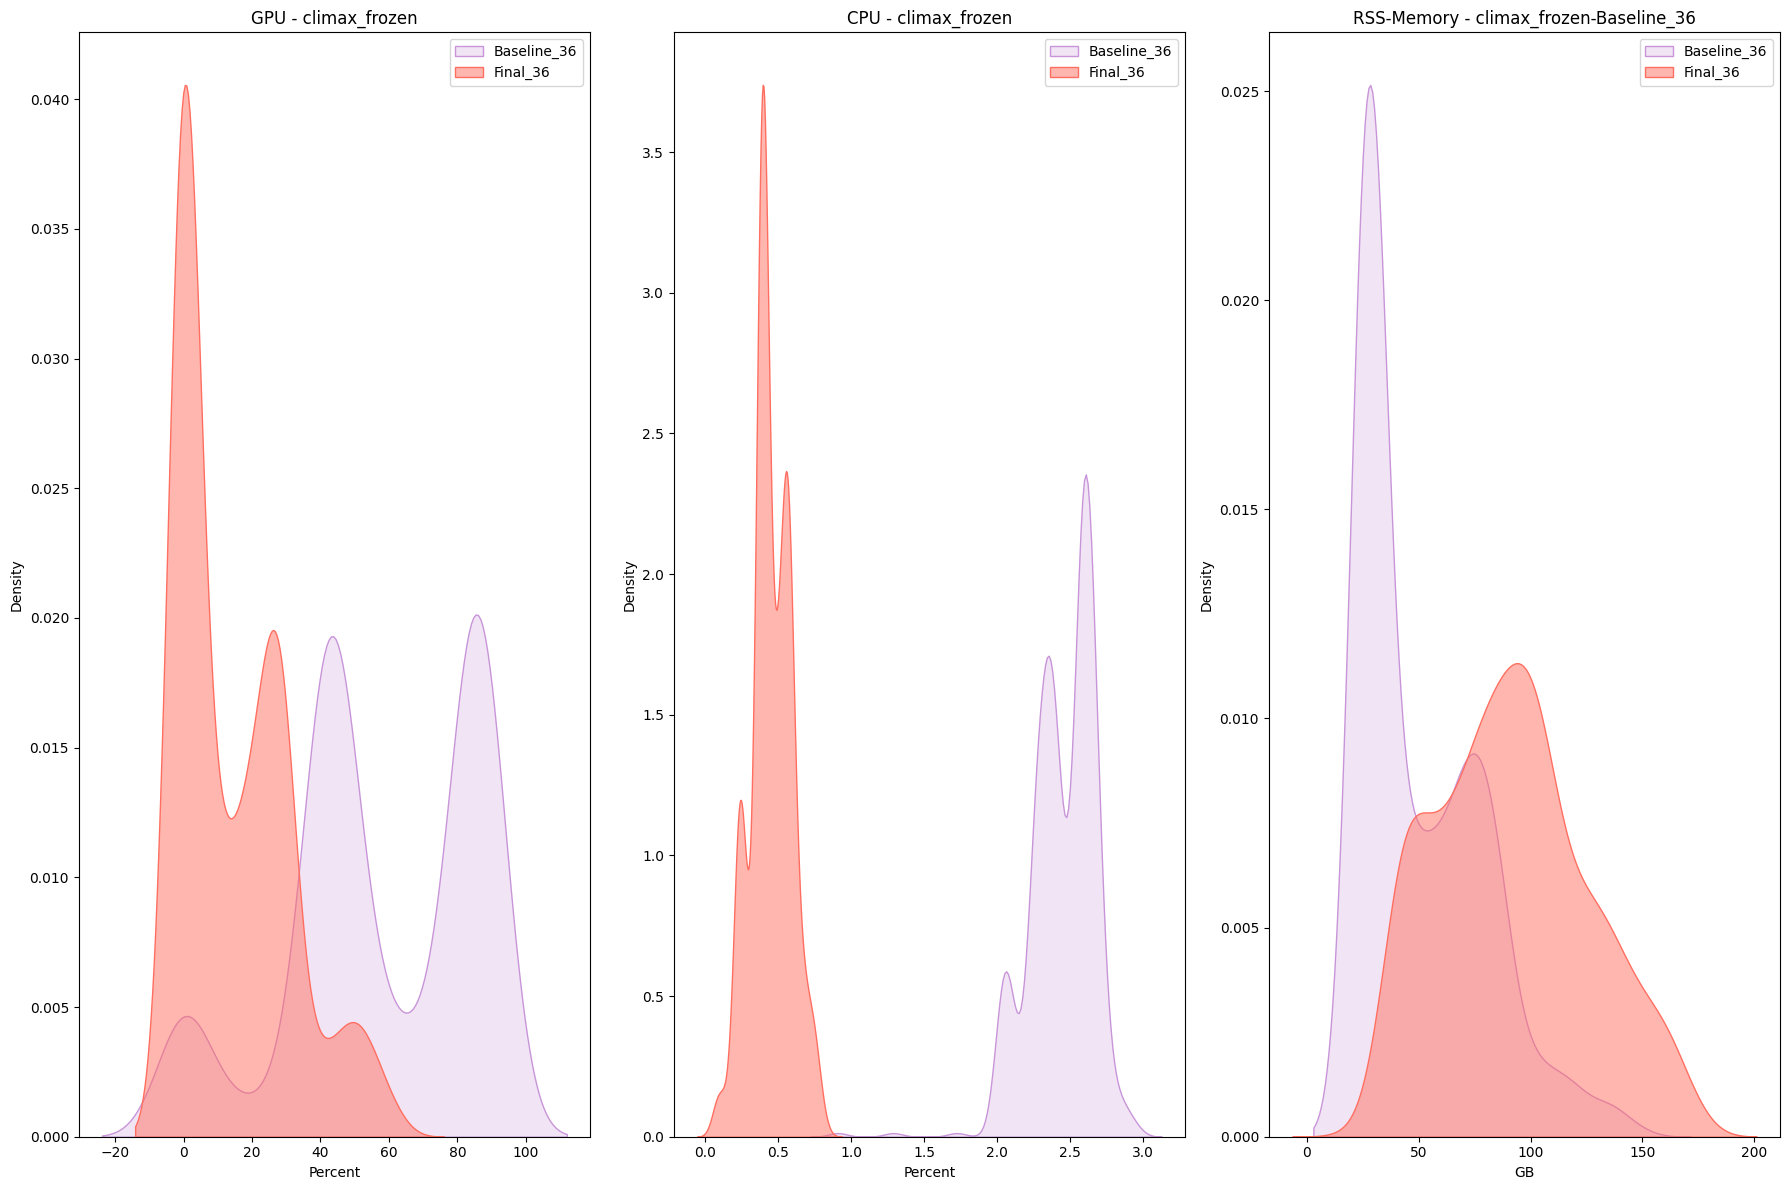

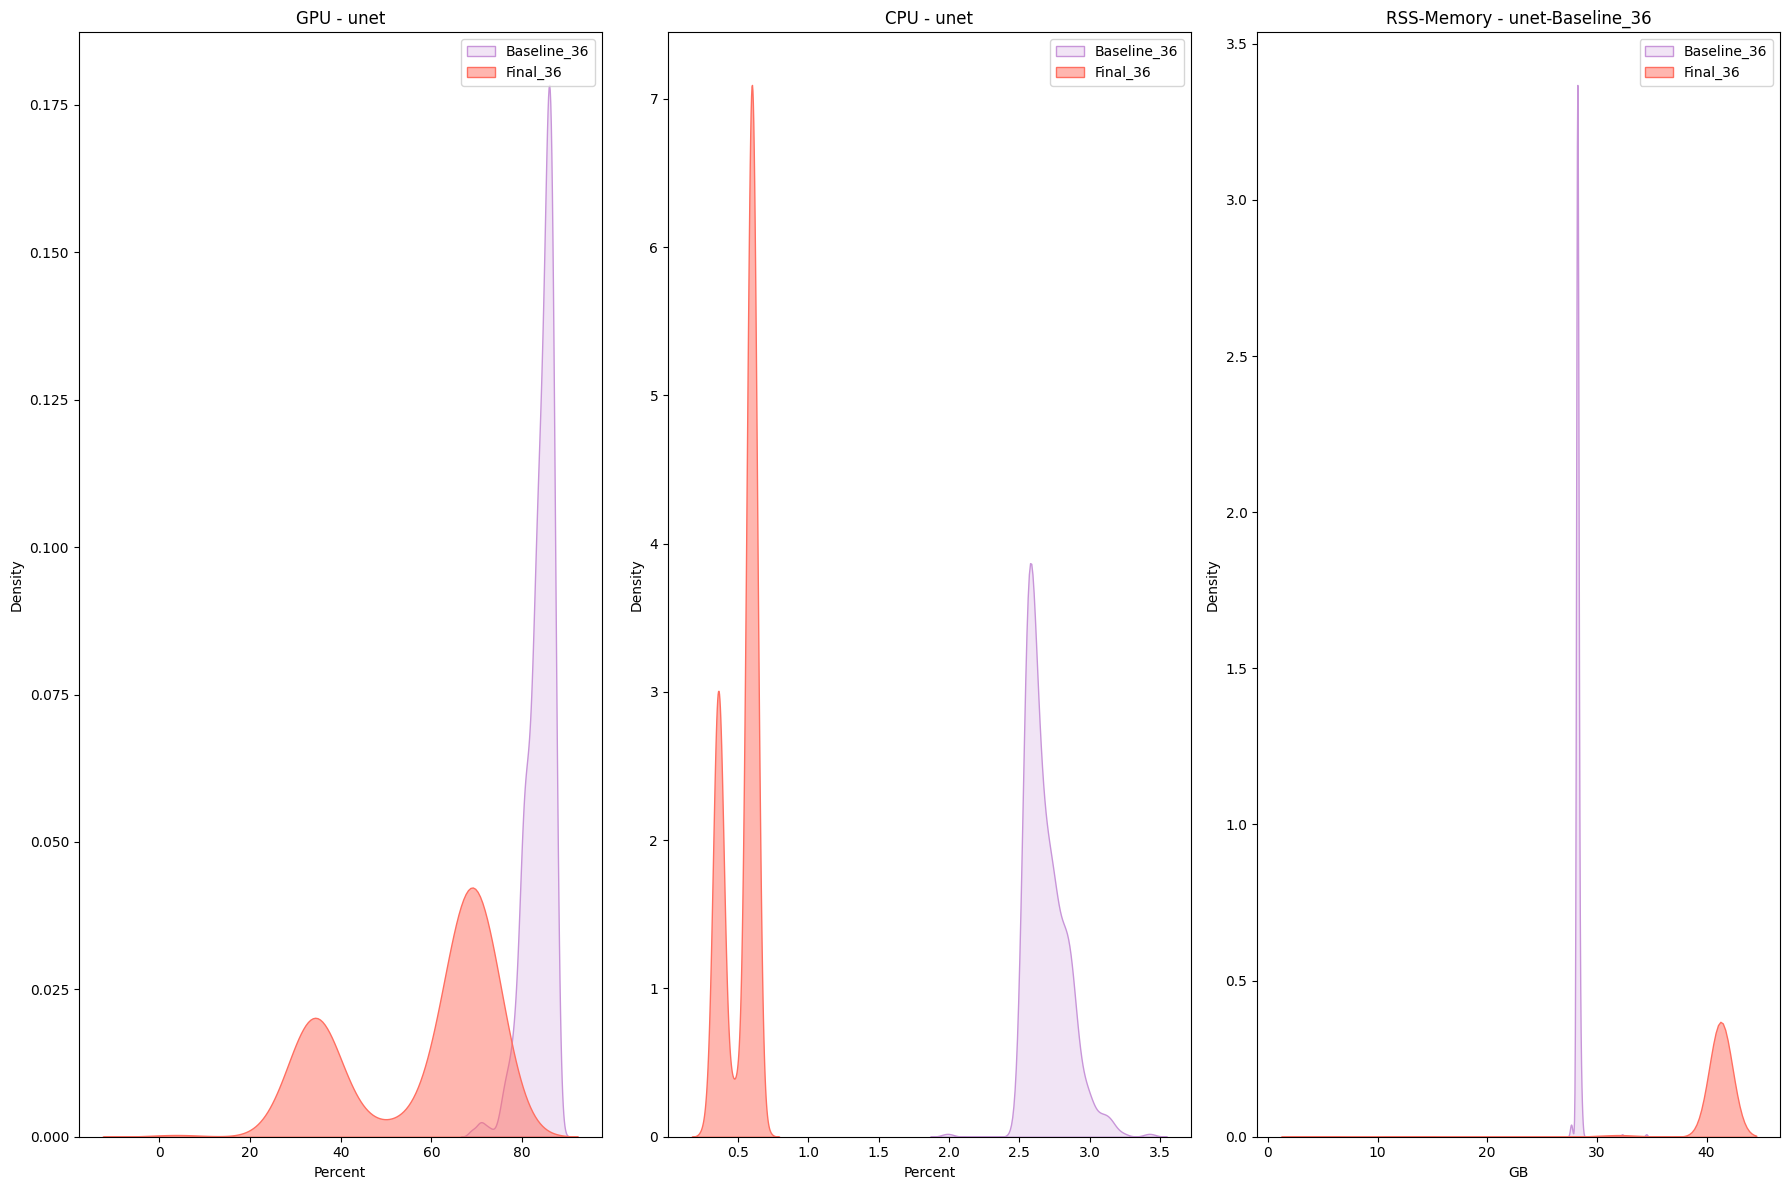

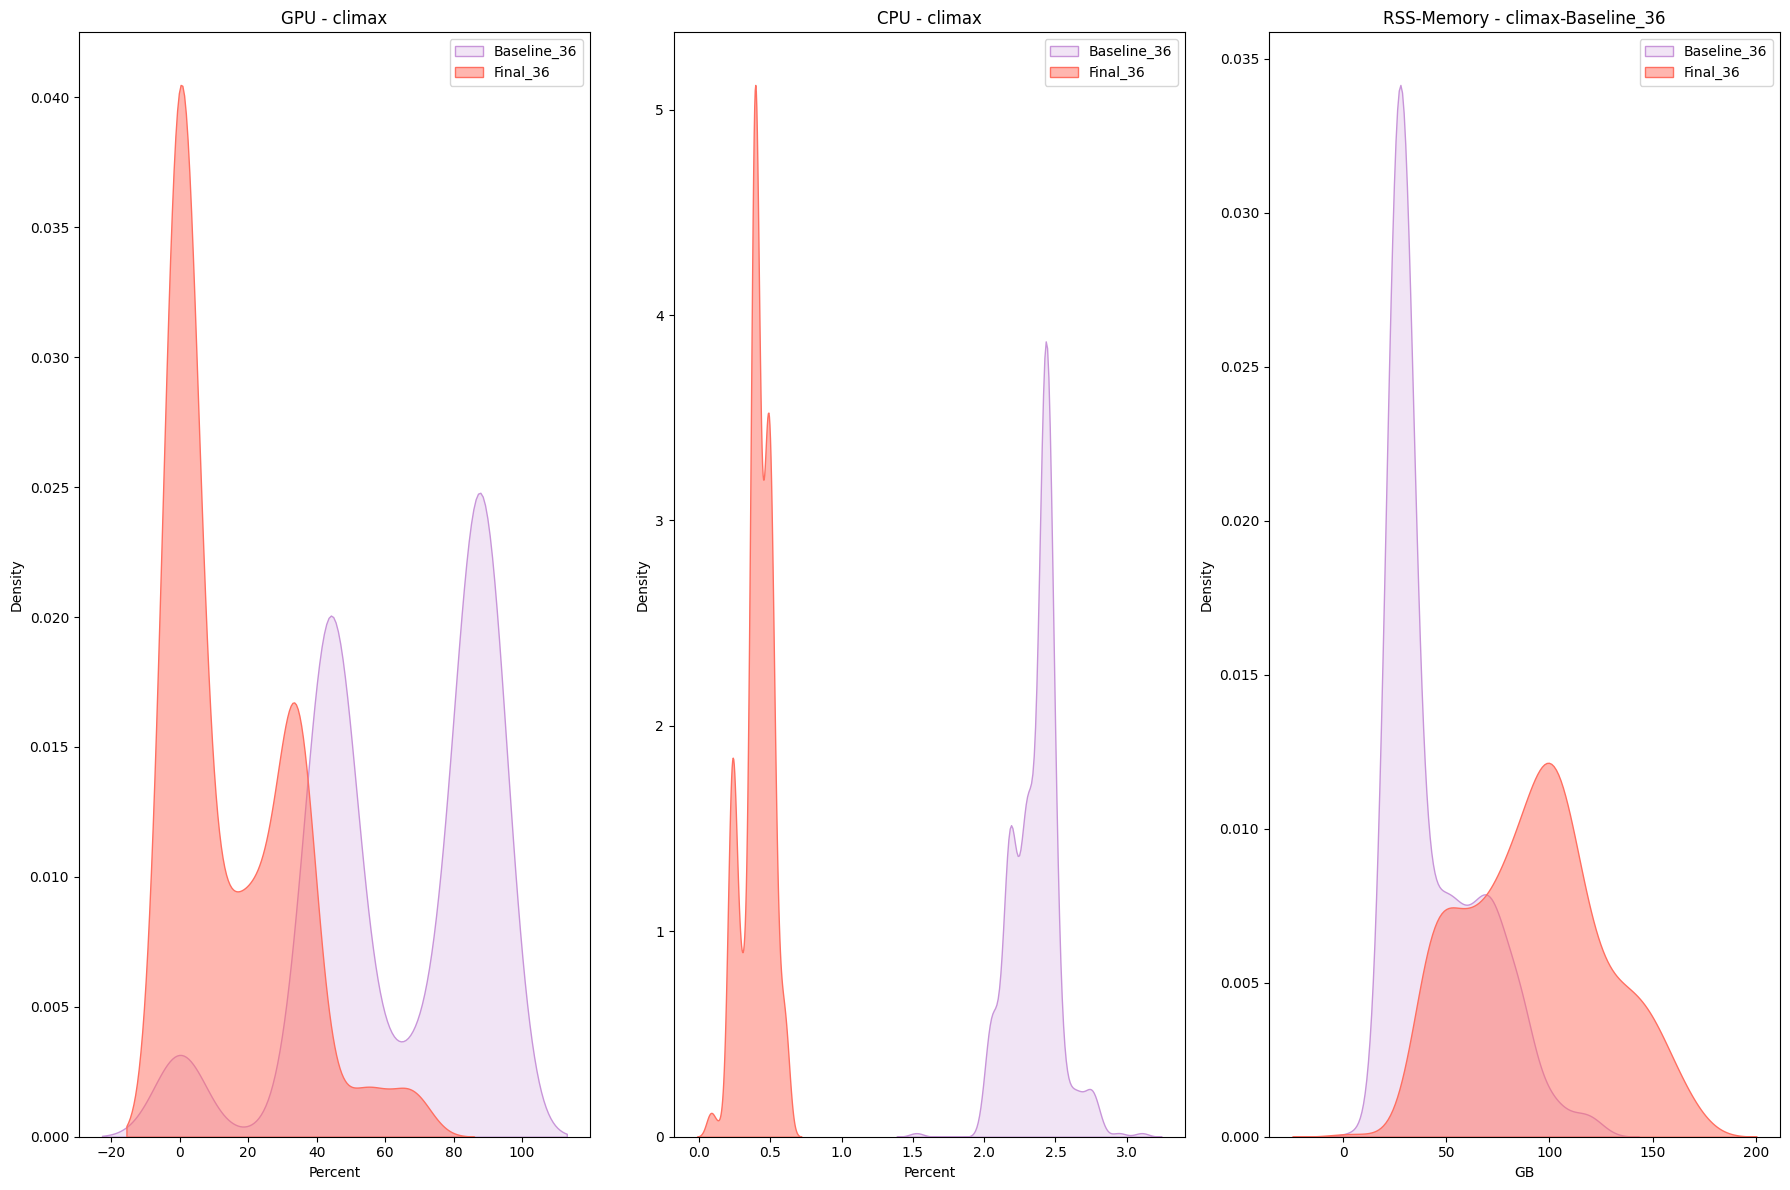

In [52]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from seaborn_qqplot import pplot
from scipy.stats import gamma
from PIL import Image
import statsmodels.api as sm 
import pylab as py 



def violin_plot(ax, data, name, unit):
    sns.violinplot(data=data, ax=ax, inner="box", color="#c895d9")
    ax.set_title(name)
    ax.set_xlabel("Data Distribution")
    ax.set_ylabel(unit)

def density_plot(ax, data, name, unit):
    sns.kdeplot(data=data, fill=True, color="#c895d9", ax=ax)
    ax.set_title(name)
    ax.set_xlabel(unit)
    ax.set_ylabel("Density")


def qq_plot(ax, data, name, line_color="#c895d9"):
    # multirow = [{"Theoretical_Quantiles":np.array((stats.norm.ppf(np.arange(1, len(data)+1) / (len(data)+1))),dtype=float), "species":0}]
    # df = pd.DataFrame(multirow)
    # df_new = df.explode("Theoretical_Quantiles").astype(float)
    # # Plot the quantiles
    # pairGrid = pplot(df_new, x="Theoretical_Quantiles",y=gamma, kind='qq', height=5, aspect=1, display_kws={"identity":False, "fit":True, "reg":True, "ci":0.025})
    # pairGrid.add_legend(title=name)
    # pairGrid.figure.savefig(f"figures/{name}")
    # sm.qqplot(np.array(data), line ='45') 
    pp = sm.ProbPlot(np.array(data), fit=True)
    qq = pp.qqplot(ax=ax, marker='.', markerfacecolor='k', alpha=0.3, color='#1f77b4')
    sm.qqline(ax=ax, line='45', fmt='k--')
    ax.set_title(name)
    
    

def density_plot_2(ax, treatment_0, treatment_1,name_0,name_1, name, unit):
    sns.kdeplot(data=treatment_0, fill=True, color="#c895d9", ax=ax, label=name_0)
    sns.kdeplot(data=treatment_1, fill=True, color="#ff6f61", ax=ax, alpha=0.5, label=name_1)
    ax.set_title(name)
    ax.set_xlabel(unit)
    ax.set_ylabel("Density")
    ax.legend()

def scale_down(data,factor=6.0):
    new_data = []
    for x in data:
        new_x = x / factor
        new_data.append(new_x)
    return new_data
        

############################################ VIOLIN & DENSITY PLOTS ############################################################

# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if number_runs >= 2:
#         name = run[0]
#         treatment = run[1]
#         data_for_run = mean_data.get((run[0], run[1]), 0)
        
#         fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a 2x3 grid of subplots
        
#         violin_plot(axes[0, 0], data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}", "Percent")
#         violin_plot(axes[0, 1], data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}", "Percent")
#         violin_plot(axes[0, 2], data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
        
#         density_plot(axes[1, 0], data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}", "Percent")
#         density_plot(axes[1, 1], data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}", "Percent")
#         density_plot(axes[1, 2], data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
        
#         plt.tight_layout()
#         fig.savefig(f"figures/RQ_1_violin_density/RQ_1_violin_density_{name}-{treatment}")    

############################################ QQ PLOTS ############################################################
# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if number_runs >= 2:
#         name = run[0]
#         treatment = run[1]
#         data_for_run = mean_data.get((run[0], run[1]), 0)

#         fig, axes = plt.subplots(1, 3, figsize=(15, 5),)  # Create a 2x3 grid of subplots

#         qq_plot(axes[0],data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}")
#         qq_plot(axes[1],data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}")
#         qq_plot(axes[2],data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}")

#         fig.savefig(f"figures/RQ_1_QQ/RQ_1_QQ_{name}-{treatment}")        
         # will now save all plots

############################################ COMBINED DENSITY PLOTS ############################################################


already_used_name=[]
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment_0 = Treatment_Names[0]
        treatment_1 = Treatment_Names[1]

        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)

        

        fig, axes = plt.subplots(1, 3, figsize=(18, 12))  # Create a 2x3 grid of subplots

        density_plot_2(axes[0], data_for_run_0["GPU"],data_for_run_1["GPU"],treatment_0,treatment_1, f"GPU - {run[0]}", "Percent")
        density_plot_2(axes[1], data_for_run_0["CPU"],data_for_run_1["CPU"],treatment_0,treatment_1, f"CPU - {run[0]}", "Percent")
        density_plot_2(axes[2], data_for_run_0["RSS-Memory in GB"],data_for_run_1["RSS-Memory in GB"],treatment_0,treatment_1, f"RSS-Memory - {run[0]}-{run[1]}", "GB")
        
        plt.tight_layout()
        fig.savefig(f"figures/RQ_3_combined_density/RQ_3_combined_density_{name}-{treatment}")        





In [53]:
from scipy import stats


data_list_shapiro = []

for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if number_runs >= 2:
        name = run[0]
        treatment = run[1]
        data_for_run = mean_data.get((run[0], run[1]), 0)
        
        SWT_GPU = stats.shapiro(data_for_run["CPU"])
        SWT_CPU = stats.shapiro(data_for_run["GPU"])
        SWT_RSS = stats.shapiro(data_for_run["RSS-Memory in GB"])
        
        data_list_shapiro.append({
            "Name": name,
            "Treatment": treatment,
            "GPU-Statistic": SWT_GPU.statistic,
            "GPU-P": SWT_GPU.pvalue,
            "CPU-Statistic": SWT_CPU.statistic,
            "CPU-P": SWT_CPU.pvalue,
            "RSS-Statistic": SWT_RSS.statistic,
            "RSS-P": SWT_RSS.pvalue
        })

# sorted_df = sorted_df.applymap(round_if_float)
# sorted_df_sf = sorted_df_sf.applymap(round_if_float)

df_Shapiro = pd.DataFrame(data_list_shapiro)
sorted_df_shapiro = df_Shapiro.sort_values(by='Name').applymap(round_if_float)
latex_table_shapiro = sorted_df_shapiro.to_latex(index=False,float_format="%.3f")

print(latex_table_shapiro)
        

\begin{tabular}{llrrrrrr}
\toprule
Name & Treatment & GPU-Statistic & GPU-P & CPU-Statistic & CPU-P & RSS-Statistic & RSS-P \\
\midrule
climax & Baseline_36 & 0.924 & 0.000 & 0.800 & 0.000 & 0.775 & 0.000 \\
climax & Final_36 & 0.947 & 0.000 & 0.791 & 0.000 & 0.980 & 0.000 \\
climax_frozen & Baseline_36 & 0.903 & 0.000 & 0.845 & 0.000 & 0.818 & 0.000 \\
climax_frozen & Final_36 & 0.971 & 0.000 & 0.828 & 0.000 & 0.972 & 0.000 \\
convlstm & Baseline_36 & 0.399 & 0.000 & 0.364 & 0.000 & 0.162 & 0.000 \\
convlstm & Final_36 & 0.308 & 0.000 & 0.598 & 0.000 & 0.120 & 0.000 \\
unet & Baseline_36 & 0.886 & 0.000 & 0.882 & 0.000 & 0.155 & 0.000 \\
unet & Final_36 & 0.701 & 0.000 & 0.771 & 0.000 & 0.142 & 0.000 \\
\bottomrule
\end{tabular}



C:\Users\fe-na\AppData\Local\Temp\ipykernel_16716\60037110.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sorted_df_shapiro = df_Shapiro.sort_values(by='Name').applymap(round_if_float)


In [54]:
data_list_rank_sum = []
already_used_name=[]
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment_0 = Treatment_Names[0]
        treatment_1 = Treatment_Names[1]

        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)
        SWT_GPU = stats.ranksums(data_for_run_0["CPU"],scale_down(data_for_run_1["CPU"]))
        SWT_CPU = stats.ranksums(data_for_run_0["GPU"],scale_down(data_for_run_1["GPU"]))
        SWT_RSS = stats.ranksums(data_for_run_0["RSS-Memory in GB"],scale_down(data_for_run_1["RSS-Memory in GB"]))

        SWT_GPU_k = stats.kstest(data_for_run_0["CPU"],scale_down(data_for_run_1["CPU"]))
        SWT_CPU_k = stats.kstest(data_for_run_0["GPU"],scale_down(data_for_run_1["GPU"]))
        SWT_RSS_k = stats.kstest(data_for_run_0["RSS-Memory in GB"],scale_down(data_for_run_1["RSS-Memory in GB"]))

        data_list_rank_sum.append({
            "Name": name,
            "GPU-Statistic-RS": SWT_GPU.statistic,
            "GPU-P-RS": SWT_GPU.pvalue,
            "GPU-Statistic-KS": SWT_GPU_k.statistic,
            "GPU-P-KS": SWT_GPU_k.pvalue,
            "CPU-Statistic-RS": SWT_CPU.statistic,
            "CPU-P-RS": SWT_CPU.pvalue,
            "CPU-Statistic-KS": SWT_CPU_k.statistic,
            "CPU-P-KS": SWT_CPU_k.pvalue,
            "RSS-Statistic-RS": SWT_RSS.statistic,
            "RSS-P-RS": SWT_RSS.pvalue,
            "RSS-Statistic-KS": SWT_RSS_k.statistic,
            "RSS-P-KS": SWT_RSS_k.pvalue
        })

data_list_rank_sum = pd.DataFrame(data_list_rank_sum)
sorted_df_rank_sum = data_list_rank_sum.sort_values(by='Name').applymap(round_if_float)
latex_table_rank_sum = sorted_df_rank_sum.to_latex(index=False,float_format="%.3f")

print(latex_table_rank_sum)

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
Name & GPU-Statistic-RS & GPU-P-RS & GPU-Statistic-KS & GPU-P-KS & CPU-Statistic-RS & CPU-P-RS & CPU-Statistic-KS & CPU-P-KS & RSS-Statistic-RS & RSS-P-RS & RSS-Statistic-KS & RSS-P-KS \\
\midrule
climax & 27.110 & 0.000 & 1.000 & 0.000 & 24.410 & 0.000 & 0.940 & 0.000 & 26.639 & 0.000 & 0.984 & 0.000 \\
climax_frozen & 26.941 & 0.000 & 1.000 & 0.000 & 23.068 & 0.000 & 0.908 & 0.000 & 26.501 & 0.000 & 0.975 & 0.000 \\
convlstm & 18.130 & 0.000 & 1.000 & 0.000 & 17.500 & 0.000 & 0.989 & 0.000 & 17.995 & 0.000 & 0.996 & 0.000 \\
unet & 22.630 & 0.000 & 1.000 & 0.000 & 22.322 & 0.000 & 1.000 & 0.000 & 22.659 & 0.000 & 1.000 & 0.000 \\
\bottomrule
\end{tabular}



C:\Users\fe-na\AppData\Local\Temp\ipykernel_16716\2364367300.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sorted_df_rank_sum = data_list_rank_sum.sort_values(by='Name').applymap(round_if_float)
